In [1]:
import argparse
import collections
import logging
import os
import struct

import numpy as np

logger = logging.getLogger(__name__)


CameraModel = collections.namedtuple(
    "CameraModel", ["model_id", "model_name", "num_params"]
)
Camera = collections.namedtuple("Camera", ["id", "model", "width", "height", "params"])
BaseImage = collections.namedtuple(
    "Image", ["id", "qvec", "tvec", "camera_id", "name", "xys", "point3D_ids"]
)
Point3D = collections.namedtuple(
    "Point3D", ["id", "xyz", "rgb", "error", "image_ids", "point2D_idxs"]
)


class Image(BaseImage):
    def qvec2rotmat(self):
        return qvec2rotmat(self.qvec)


CAMERA_MODELS = {
    CameraModel(model_id=0, model_name="SIMPLE_PINHOLE", num_params=3),
    CameraModel(model_id=1, model_name="PINHOLE", num_params=4),
    CameraModel(model_id=2, model_name="SIMPLE_RADIAL", num_params=4),
    CameraModel(model_id=3, model_name="RADIAL", num_params=5),
    CameraModel(model_id=4, model_name="OPENCV", num_params=8),
    CameraModel(model_id=5, model_name="OPENCV_FISHEYE", num_params=8),
    CameraModel(model_id=6, model_name="FULL_OPENCV", num_params=12),
    CameraModel(model_id=7, model_name="FOV", num_params=5),
    CameraModel(model_id=8, model_name="SIMPLE_RADIAL_FISHEYE", num_params=4),
    CameraModel(model_id=9, model_name="RADIAL_FISHEYE", num_params=5),
    CameraModel(model_id=10, model_name="THIN_PRISM_FISHEYE", num_params=12),
}
CAMERA_MODEL_IDS = dict(
    [(camera_model.model_id, camera_model) for camera_model in CAMERA_MODELS]
)
CAMERA_MODEL_NAMES = dict(
    [(camera_model.model_name, camera_model) for camera_model in CAMERA_MODELS]
)


def read_next_bytes(fid, num_bytes, format_char_sequence, endian_character="<"):
    """Read and unpack the next bytes from a binary file.
    :param fid:
    :param num_bytes: Sum of combination of {2, 4, 8}, e.g. 2, 6, 16, 30, etc.
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    :param endian_character: Any of {@, =, <, >, !}
    :return: Tuple of read and unpacked values.
    """
    data = fid.read(num_bytes)
    return struct.unpack(endian_character + format_char_sequence, data)


def write_next_bytes(fid, data, format_char_sequence, endian_character="<"):
    """pack and write to a binary file.
    :param fid:
    :param data: data to send, if multiple elements are sent at the same time,
    they should be encapsuled either in a list or a tuple
    :param format_char_sequence: List of {c, e, f, d, h, H, i, I, l, L, q, Q}.
    should be the same length as the data list or tuple
    :param endian_character: Any of {@, =, <, >, !}
    """
    if isinstance(data, (list, tuple)):
        bytes = struct.pack(endian_character + format_char_sequence, *data)
    else:
        bytes = struct.pack(endian_character + format_char_sequence, data)
    fid.write(bytes)


def read_cameras_text(path):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::WriteCamerasText(const std::string& path)
        void Reconstruction::ReadCamerasText(const std::string& path)
    """
    cameras = {}
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                camera_id = int(elems[0])
                model = elems[1]
                width = int(elems[2])
                height = int(elems[3])
                params = np.array(tuple(map(float, elems[4:])))
                cameras[camera_id] = Camera(
                    id=camera_id, model=model, width=width, height=height, params=params
                )
    return cameras


def read_cameras_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::WriteCamerasBinary(const std::string& path)
        void Reconstruction::ReadCamerasBinary(const std::string& path)
    """
    cameras = {}
    with open(path_to_model_file, "rb") as fid:
        num_cameras = read_next_bytes(fid, 8, "Q")[0]
        for _ in range(num_cameras):
            camera_properties = read_next_bytes(
                fid, num_bytes=24, format_char_sequence="iiQQ"
            )
            camera_id = camera_properties[0]
            model_id = camera_properties[1]
            model_name = CAMERA_MODEL_IDS[camera_properties[1]].model_name
            width = camera_properties[2]
            height = camera_properties[3]
            num_params = CAMERA_MODEL_IDS[model_id].num_params
            params = read_next_bytes(
                fid, num_bytes=8 * num_params, format_char_sequence="d" * num_params
            )
            cameras[camera_id] = Camera(
                id=camera_id,
                model=model_name,
                width=width,
                height=height,
                params=np.array(params),
            )
        assert len(cameras) == num_cameras
    return cameras


def write_cameras_text(cameras, path):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::WriteCamerasText(const std::string& path)
        void Reconstruction::ReadCamerasText(const std::string& path)
    """
    HEADER = (
        "# Camera list with one line of data per camera:\n"
        + "#   CAMERA_ID, MODEL, WIDTH, HEIGHT, PARAMS[]\n"
        + "# Number of cameras: {}\n".format(len(cameras))
    )
    with open(path, "w") as fid:
        fid.write(HEADER)
        for _, cam in cameras.items():
            to_write = [cam.id, cam.model, cam.width, cam.height, *cam.params]
            line = " ".join([str(elem) for elem in to_write])
            fid.write(line + "\n")


def write_cameras_binary(cameras, path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::WriteCamerasBinary(const std::string& path)
        void Reconstruction::ReadCamerasBinary(const std::string& path)
    """
    with open(path_to_model_file, "wb") as fid:
        write_next_bytes(fid, len(cameras), "Q")
        for _, cam in cameras.items():
            model_id = CAMERA_MODEL_NAMES[cam.model].model_id
            camera_properties = [cam.id, model_id, cam.width, cam.height]
            write_next_bytes(fid, camera_properties, "iiQQ")
            for p in cam.params:
                write_next_bytes(fid, float(p), "d")
    return cameras


def read_images_text(path):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesText(const std::string& path)
        void Reconstruction::WriteImagesText(const std::string& path)
    """
    images = {}
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                image_id = int(elems[0])
                qvec = np.array(tuple(map(float, elems[1:5])))
                tvec = np.array(tuple(map(float, elems[5:8])))
                camera_id = int(elems[8])
                image_name = elems[9]
                elems = fid.readline().split()
                xys = np.column_stack(
                    [tuple(map(float, elems[0::3])), tuple(map(float, elems[1::3]))]
                )
                point3D_ids = np.array(tuple(map(int, elems[2::3])))
                images[image_id] = Image(
                    id=image_id,
                    qvec=qvec,
                    tvec=tvec,
                    camera_id=camera_id,
                    name=image_name,
                    xys=xys,
                    point3D_ids=point3D_ids,
                )
    return images


def read_images_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    images = {}
    with open(path_to_model_file, "rb") as fid:
        num_reg_images = read_next_bytes(fid, 8, "Q")[0]
        for _ in range(num_reg_images):
            binary_image_properties = read_next_bytes(
                fid, num_bytes=64, format_char_sequence="idddddddi"
            )
            image_id = binary_image_properties[0]
            qvec = np.array(binary_image_properties[1:5])
            tvec = np.array(binary_image_properties[5:8])
            camera_id = binary_image_properties[8]
            image_name = ""
            current_char = read_next_bytes(fid, 1, "c")[0]
            while current_char != b"\x00":  # look for the ASCII 0 entry
                image_name += current_char.decode("utf-8")
                current_char = read_next_bytes(fid, 1, "c")[0]
            num_points2D = read_next_bytes(fid, num_bytes=8, format_char_sequence="Q")[
                0
            ]
            x_y_id_s = read_next_bytes(
                fid,
                num_bytes=24 * num_points2D,
                format_char_sequence="ddq" * num_points2D,
            )
            xys = np.column_stack(
                [tuple(map(float, x_y_id_s[0::3])), tuple(map(float, x_y_id_s[1::3]))]
            )
            point3D_ids = np.array(tuple(map(int, x_y_id_s[2::3])))
            images[image_id] = Image(
                id=image_id,
                qvec=qvec,
                tvec=tvec,
                camera_id=camera_id,
                name=image_name,
                xys=xys,
                point3D_ids=point3D_ids,
            )
    return images


def write_images_text(images, path):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesText(const std::string& path)
        void Reconstruction::WriteImagesText(const std::string& path)
    """
    if len(images) == 0:
        mean_observations = 0
    else:
        mean_observations = sum(
            (len(img.point3D_ids) for _, img in images.items())
        ) / len(images)
    HEADER = (
        "# Image list with two lines of data per image:\n"
        + "#   IMAGE_ID, QW, QX, QY, QZ, TX, TY, TZ, CAMERA_ID, NAME\n"
        + "#   POINTS2D[] as (X, Y, POINT3D_ID)\n"
        + "# Number of images: {}, mean observations per image: {}\n".format(
            len(images), mean_observations
        )
    )

    with open(path, "w") as fid:
        fid.write(HEADER)
        for _, img in images.items():
            image_header = [img.id, *img.qvec, *img.tvec, img.camera_id, img.name]
            first_line = " ".join(map(str, image_header))
            fid.write(first_line + "\n")

            points_strings = []
            for xy, point3D_id in zip(img.xys, img.point3D_ids):
                points_strings.append(" ".join(map(str, [*xy, point3D_id])))
            fid.write(" ".join(points_strings) + "\n")


def write_images_binary(images, path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadImagesBinary(const std::string& path)
        void Reconstruction::WriteImagesBinary(const std::string& path)
    """
    with open(path_to_model_file, "wb") as fid:
        write_next_bytes(fid, len(images), "Q")
        for _, img in images.items():
            write_next_bytes(fid, img.id, "i")
            write_next_bytes(fid, img.qvec.tolist(), "dddd")
            write_next_bytes(fid, img.tvec.tolist(), "ddd")
            write_next_bytes(fid, img.camera_id, "i")
            for char in img.name:
                write_next_bytes(fid, char.encode("utf-8"), "c")
            write_next_bytes(fid, b"\x00", "c")
            write_next_bytes(fid, len(img.point3D_ids), "Q")
            for xy, p3d_id in zip(img.xys, img.point3D_ids):
                write_next_bytes(fid, [*xy, p3d_id], "ddq")


def read_points3D_text(path):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadPoints3DText(const std::string& path)
        void Reconstruction::WritePoints3DText(const std::string& path)
    """
    points3D = {}
    with open(path, "r") as fid:
        while True:
            line = fid.readline()
            if not line:
                break
            line = line.strip()
            if len(line) > 0 and line[0] != "#":
                elems = line.split()
                point3D_id = int(elems[0])
                xyz = np.array(tuple(map(float, elems[1:4])))
                rgb = np.array(tuple(map(int, elems[4:7])))
                error = float(elems[7])
                image_ids = np.array(tuple(map(int, elems[8::2])))
                point2D_idxs = np.array(tuple(map(int, elems[9::2])))
                points3D[point3D_id] = Point3D(
                    id=point3D_id,
                    xyz=xyz,
                    rgb=rgb,
                    error=error,
                    image_ids=image_ids,
                    point2D_idxs=point2D_idxs,
                )
    return points3D


def read_points3D_binary(path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadPoints3DBinary(const std::string& path)
        void Reconstruction::WritePoints3DBinary(const std::string& path)
    """
    points3D = {}
    with open(path_to_model_file, "rb") as fid:
        num_points = read_next_bytes(fid, 8, "Q")[0]
        for _ in range(num_points):
            binary_point_line_properties = read_next_bytes(
                fid, num_bytes=43, format_char_sequence="QdddBBBd"
            )
            point3D_id = binary_point_line_properties[0]
            xyz = np.array(binary_point_line_properties[1:4])
            rgb = np.array(binary_point_line_properties[4:7])
            error = np.array(binary_point_line_properties[7])
            track_length = read_next_bytes(fid, num_bytes=8, format_char_sequence="Q")[
                0
            ]
            track_elems = read_next_bytes(
                fid,
                num_bytes=8 * track_length,
                format_char_sequence="ii" * track_length,
            )
            image_ids = np.array(tuple(map(int, track_elems[0::2])))
            point2D_idxs = np.array(tuple(map(int, track_elems[1::2])))
            points3D[point3D_id] = Point3D(
                id=point3D_id,
                xyz=xyz,
                rgb=rgb,
                error=error,
                image_ids=image_ids,
                point2D_idxs=point2D_idxs,
            )
    return points3D


def write_points3D_text(points3D, path):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadPoints3DText(const std::string& path)
        void Reconstruction::WritePoints3DText(const std::string& path)
    """
    if len(points3D) == 0:
        mean_track_length = 0
    else:
        mean_track_length = sum(
            (len(pt.image_ids) for _, pt in points3D.items())
        ) / len(points3D)
    HEADER = (
        "# 3D point list with one line of data per point:\n"
        + "#   POINT3D_ID, X, Y, Z, R, G, B, ERROR, TRACK[] as (IMAGE_ID, POINT2D_IDX)\n"  # noqa: E501
        + "# Number of points: {}, mean track length: {}\n".format(
            len(points3D), mean_track_length
        )
    )

    with open(path, "w") as fid:
        fid.write(HEADER)
        for _, pt in points3D.items():
            point_header = [pt.id, *pt.xyz, *pt.rgb, pt.error]
            fid.write(" ".join(map(str, point_header)) + " ")
            track_strings = []
            for image_id, point2D in zip(pt.image_ids, pt.point2D_idxs):
                track_strings.append(" ".join(map(str, [image_id, point2D])))
            fid.write(" ".join(track_strings) + "\n")


def write_points3D_binary(points3D, path_to_model_file):
    """
    see: src/base/reconstruction.cc
        void Reconstruction::ReadPoints3DBinary(const std::string& path)
        void Reconstruction::WritePoints3DBinary(const std::string& path)
    """
    with open(path_to_model_file, "wb") as fid:
        write_next_bytes(fid, len(points3D), "Q")
        for _, pt in points3D.items():
            write_next_bytes(fid, pt.id, "Q")
            write_next_bytes(fid, pt.xyz.tolist(), "ddd")
            write_next_bytes(fid, pt.rgb.tolist(), "BBB")
            write_next_bytes(fid, pt.error, "d")
            track_length = pt.image_ids.shape[0]
            write_next_bytes(fid, track_length, "Q")
            for image_id, point2D_id in zip(pt.image_ids, pt.point2D_idxs):
                write_next_bytes(fid, [image_id, point2D_id], "ii")


def detect_model_format(path, ext):
    if (
        os.path.isfile(os.path.join(path, "cameras" + ext))
        and os.path.isfile(os.path.join(path, "images" + ext))
        and os.path.isfile(os.path.join(path, "points3D" + ext))
    ):
        return True

    return False


def read_model(path, ext=""):
    # try to detect the extension automatically
    if ext == "":
        if detect_model_format(path, ".bin"):
            ext = ".bin"
        elif detect_model_format(path, ".txt"):
            ext = ".txt"
        else:
            try:
                cameras, images, points3D = read_model(os.path.join(path, "model/"))
                logger.warning("This SfM file structure was deprecated in hloc v1.1")
                return cameras, images, points3D
            except FileNotFoundError:
                raise FileNotFoundError(
                    f"Could not find binary or text COLMAP model at {path}"
                )

    if ext == ".txt":
        cameras = read_cameras_text(os.path.join(path, "cameras" + ext))
        images = read_images_text(os.path.join(path, "images" + ext))
        points3D = read_points3D_text(os.path.join(path, "points3D") + ext)
    else:
        cameras = read_cameras_binary(os.path.join(path, "cameras" + ext))
        images = read_images_binary(os.path.join(path, "images" + ext))
        points3D = read_points3D_binary(os.path.join(path, "points3D") + ext)
    return cameras, images, points3D


def write_model(cameras, images, points3D, path, ext=".bin"):
    if ext == ".txt":
        write_cameras_text(cameras, os.path.join(path, "cameras" + ext))
        write_images_text(images, os.path.join(path, "images" + ext))
        write_points3D_text(points3D, os.path.join(path, "points3D") + ext)
    else:
        write_cameras_binary(cameras, os.path.join(path, "cameras" + ext))
        write_images_binary(images, os.path.join(path, "images" + ext))
        write_points3D_binary(points3D, os.path.join(path, "points3D") + ext)
    return cameras, images, points3D


def qvec2rotmat(qvec):
    return np.array(
        [
            [
                1 - 2 * qvec[2] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[1] * qvec[2] - 2 * qvec[0] * qvec[3],
                2 * qvec[3] * qvec[1] + 2 * qvec[0] * qvec[2],
            ],
            [
                2 * qvec[1] * qvec[2] + 2 * qvec[0] * qvec[3],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[3] ** 2,
                2 * qvec[2] * qvec[3] - 2 * qvec[0] * qvec[1],
            ],
            [
                2 * qvec[3] * qvec[1] - 2 * qvec[0] * qvec[2],
                2 * qvec[2] * qvec[3] + 2 * qvec[0] * qvec[1],
                1 - 2 * qvec[1] ** 2 - 2 * qvec[2] ** 2,
            ],
        ]
    )


def rotmat2qvec(R):
    Rxx, Ryx, Rzx, Rxy, Ryy, Rzy, Rxz, Ryz, Rzz = R.flat
    K = (
        np.array(
            [
                [Rxx - Ryy - Rzz, 0, 0, 0],
                [Ryx + Rxy, Ryy - Rxx - Rzz, 0, 0],
                [Rzx + Rxz, Rzy + Ryz, Rzz - Rxx - Ryy, 0],
                [Ryz - Rzy, Rzx - Rxz, Rxy - Ryx, Rxx + Ryy + Rzz],
            ]
        )
        / 3.0
    )
    eigvals, eigvecs = np.linalg.eigh(K)
    qvec = eigvecs[[3, 0, 1, 2], np.argmax(eigvals)]
    if qvec[0] < 0:
        qvec *= -1
    return qvec


def main():
    parser = argparse.ArgumentParser(
        description="Read and write COLMAP binary and text models"
    )
    parser.add_argument("--input_model", help="path to input model folder")
    parser.add_argument(
        "--input_format",
        choices=[".bin", ".txt"],
        help="input model format",
        default="",
    )
    parser.add_argument("--output_model", help="path to output model folder")
    parser.add_argument(
        "--output_format",
        choices=[".bin", ".txt"],
        help="outut model format",
        default=".txt",
    )
    args = parser.parse_args()

    cameras, images, points3D = read_model(path=args.input_model, ext=args.input_format)

    print("num_cameras:", len(cameras))
    print("num_images:", len(images))
    print("num_points3D:", len(points3D))

    if args.output_model is not None:
        write_model(
            cameras, images, points3D, path=args.output_model, ext=args.output_format
        )


In [4]:
images = read_cameras_binary("D:/gs-localization/output/7scenes_full_dslam/chess/sfm_superpoint+superglue/cameras.bin")
images

{1: Camera(id=1, model='SIMPLE_PINHOLE', width=640, height=480, params=array([525., 320., 240.]))}

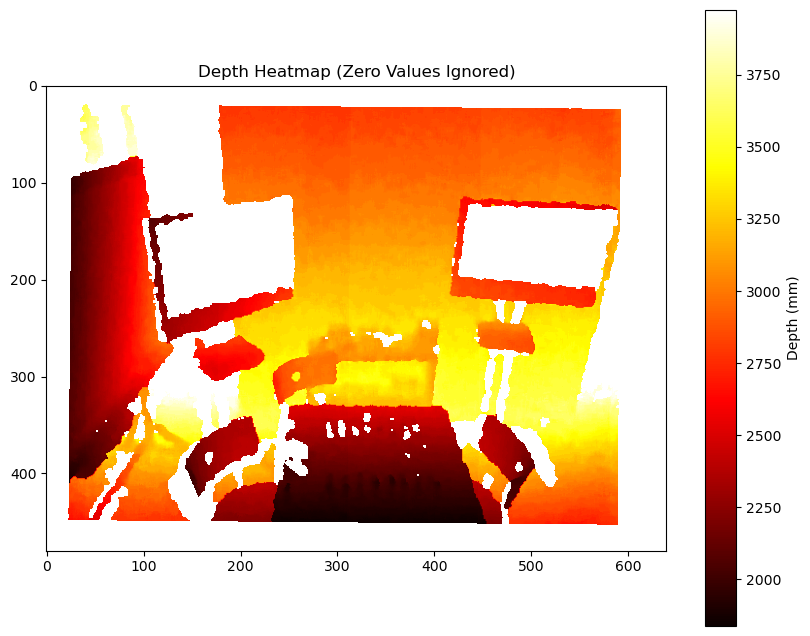

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# 读取深度图文件
depth_image_path = r'D:\gs-localization\datasets\7Scenes_additional\chess\seq-01\frame-000000.depth_cali.png'
depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED)

# 如果图像数据是以毫米为单位，可以直接转换为浮点数
depth_image = depth_image.astype(np.float32)

# 对深度图大于0的部分进行掩码处理
masked_depth_image = np.ma.masked_equal(depth_image, 0)

# 将深度图绘制为热点图，忽略为0的部分
plt.figure(figsize=(10, 8))
plt.imshow(masked_depth_image, cmap='hot')
plt.colorbar(label='Depth (mm)')
plt.title('Depth Heatmap (Zero Values Ignored)')
plt.show()

